好きな数字を入力してください7


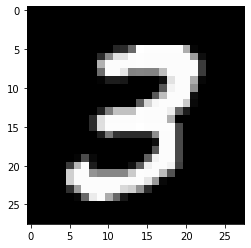

正しい結果: 3
予想結果: 2


In [3]:
#課題１

import numpy as np
import mnist
import matplotlib.pyplot as plt
from pylab import cm

#乱数固定
np.random.seed(0)
#キーボードからの入力
idx = int(input("好きな数字を入力してください"))
#画像サイズ
size = 28*28
#中間層の数
M = 50
#画像枚数
amount = 10000
#クラス数
classes = 10
#テストデータ
X = mnist.download_and_parse_mnist_file("train-images-idx3-ubyte.gz")
Y = mnist.download_and_parse_mnist_file("train-labels-idx1-ubyte.gz")

#size次元ベクトルへ変換
X_vector = X[idx].reshape([size])

#シグモイド関数
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))
#ソフトマックス関数
def softmax(x):
    u = np.sum(np.exp(x))
    return np.exp(x)/u
#乱数生成
W_1 = np.random.normal(0, np.sqrt(1/size),(M,size))
b_1 = np.random.normal(0, np.sqrt(1/size),M)
W_2 = np.random.normal(0, np.sqrt(1/M), (classes,M))
b_2 = np.random.normal(0, np.sqrt(1/M), classes)
#中間層の出力
y_1 = sigmoid(np.dot(W_1,X_vector)+b_1)

#出力
a = np.dot(W_2,y_1) + b_2
alpha = np.full(classes,np.amax(a))
y_2 = softmax(a-alpha)
y = np.argmax(y_2) + 1
#結果
plt.imshow(X[idx], cmap=cm.gray)
plt.show()
print("正しい結果: " + str(Y[idx]))
print("予想結果: " + str(y))

In [5]:
#課題2

import numpy as np
import mnist
import matplotlib.pyplot as plt
from pylab import cm

#乱数固定
np.random.seed(0)
#画像サイズ
size = 28*28
#中間層の数
M = 50
#画像枚数
amount = 10000
#クラス数
classes = 10
#データ
X = mnist.download_and_parse_mnist_file("train-images-idx3-ubyte.gz")
Y = mnist.download_and_parse_mnist_file("train-labels-idx1-ubyte.gz")
#バッチサイズ
B = 100
#ランダムなインデックス抽出
minibach = np.random.choice(10000, B, replace=False)
#乱数生成
W_1 = np.random.normal(0, np.sqrt(1/size),(M,size)) #M x size
b_1 = np.random.normal(0, np.sqrt(1/size),M) 
W_2 = np.random.normal(0, np.sqrt(1/M), (classes,M)) #classes x M
b_2 = np.random.normal(0, np.sqrt(1/M), classes)
#シグモイド関数
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))
#ソフトマックス関数
def softmax(x):
    u = np.sum(np.exp(x),axis=0)
    return np.exp(x)/u


#size x Bの行列へ変換
X_matrix = []
for i in range(B):
    X_matrix.append(X[minibach[i]].reshape([size]))
X_matrix = np.array(X_matrix).T #size x B

#中間層の出力
y_1 = sigmoid(np.dot(W_1,X_matrix)+b_1[:,np.newaxis]) # M x B

#ソフトマックス
a = np.dot(W_2,y_1) + b_2[:,np.newaxis] # classes x B
alpha = np.max(a,axis=0)#各列の最大値B個
y_pred = softmax(a - alpha[np.newaxis,:]) #それぞれのバッチのソフトマックス
y_index_pred = np.argmax(y_pred,axis=0)  #それぞれのバッチの予測

#クロスエントロピーの計算
#正しいインデックスのonehotvector
y_true = np.array([np.eye(10)[y] for y in Y[minibach]],dtype="int8").T  # 10 x B
cross_entropy_list = -np.sum(y_true * np.log(y_pred + 1e-15),axis = 0)
cross_entropy = np.sum(cross_entropy_list)/B


#結果
print("クロスエントロピー:"+ str(cross_entropy))
print("正しい結果: " + str(Y[minibach]))
print("予想結果: " + str(y_index_pred))

クロスエントロピー:2.6450292775431037
正しい結果: [9 7 9 7 5 6 5 5 2 8 5 0 5 9 4 4 6 7 9 4 6 2 4 1 5 0 2 1 1 4 4 2 3 9 5 6 4
 0 9 3 6 4 5 7 3 2 9 0 2 6 9 1 0 4 4 9 3 1 2 2 3 0 8 3 7 1 1 2 0 4 4 2 4 0
 3 4 0 1 8 0 6 9 6 7 6 1 0 4 2 6 1 6 2 7 6 3 1 3 2 8]
予想結果: [0 0 7 0 7 7 7 7 7 0 3 3 0 7 0 0 0 0 7 0 7 0 7 0 3 0 7 7 0 3 0 3 3 0 3 0 3
 3 3 0 7 0 3 0 3 3 3 0 0 0 0 0 3 0 0 3 0 3 7 3 0 3 3 3 7 0 0 7 7 0 0 0 7 7
 3 7 3 0 0 3 3 0 7 7 0 0 3 3 7 3 0 3 3 7 3 3 0 3 0 0]


In [54]:
#課題3

import numpy as np
import mnist
import matplotlib.pyplot as plt
from pylab import cm
import itertools

#乱数固定
np.random.seed(0)
#学習率
eta = 0.01
#エポック数
epoch = 20
#画像サイズ
size = 28*28
#中間層の数
M = 50
#画像枚数
train_data_size = 54000
test_data_size = 6000
#クラス数
classes = 10
#データ
X = mnist.download_and_parse_mnist_file("train-images-idx3-ubyte.gz")
Y = mnist.download_and_parse_mnist_file("train-labels-idx1-ubyte.gz")
#バッチサイズ
B = 100

#シグモイド関数
def sigmoid(x):
#     positive_index = x > 32
#     negative_index = x < -32
    
#     x =np.clip(x, -32, 32)
    s = 1.0 / (1.0 + np.exp(-x))
    
#     s[positive_index] = 1.0
#     s[negative_index] = 0.0
    return s
#ソフトマックス関数
def softmax(x):
    u = np.sum(np.exp(x),axis=0)
    return np.exp(x)/u



#乱数生成
W_1 = np.random.normal(0, np.sqrt(1/size),(M,size)) #M x size
b_1 = np.random.normal(0, np.sqrt(1/size),M) 
W_2 = np.random.normal(0, np.sqrt(1/M), (classes,M)) #classes x M
b_2 = np.random.normal(0, np.sqrt(1/M), classes)

#クロスエントロピー
each_cross_entropy = 0

def forward(W_1,W_2,b_1,b_2,data_size,test_flag):
    #ランダムなインデックス抽出
    minibach = np.random.choice(data_size, B, replace=False) + test_flag*train_data_size
#     print(minibach)
    #size x Bの行列へ変換
    X_matrix = []
    for i in range(B):
        X_matrix.append(X[minibach[i]].reshape([size]))
    X_matrix = np.array(X_matrix).T #size x B
    X_matrix = X_matrix/255

    #中間層の出力
    y_1 = sigmoid(np.dot(W_1,X_matrix)+b_1[:,np.newaxis]) # M x B

    #ソフトマックス
    a = np.dot(W_2,y_1) + b_2[:,np.newaxis] # classes x B
    alpha = np.max(a,axis=0)#各列の最大値B個
    y_pred = softmax(a - alpha[np.newaxis,:]) #それぞれのバッチのソフトマックス #10 x B
    y_index_pred = np.argmax(y_pred,axis=0)  #それぞれのバッチの予測
    y_true = np.array([np.eye(10)[y] for y in Y[minibach]],dtype="int8").T  # 10 x B
    
    return(X_matrix, y_1, y_pred,y_index_pred, y_true, minibach)
    
def backward(y_pred, y_true, y_1, X_matrix, W_1, W_2,b_1, b_2):
    #全結合層の逆伝播
    #del En/del akを求める
    del_en_del_ak = (y_pred - y_true)/B #C x B
    # print(del_en_del_ak)
    #del En/del X
    del_en_del_x = np.dot(W_2.T,del_en_del_ak) # M x B
    # print(del_en_del_x) 
    #del En/del W_2
    del_en_del_w_2 = np.dot(del_en_del_ak, y_1.T) #C x M
    #del En/del b_2
    del_en_del_b_2 = np.sum(del_en_del_ak,axis=1) #B
    # print(del_en_del_b_2)


    #シグモイド関数の逆伝播
    #シグモイドの微分
    def del_sigmoid(y):
        return (1 - y)  * y
    #del En/del X
    del_en_del_x_1 = del_en_del_x * del_sigmoid(y_1)
    
    
    
    #del En/del W
    del_en_del_w_1 = np.dot(del_en_del_x_1, X_matrix.T)
    #del En/del b
    del_en_del_b_1 = np.sum(del_en_del_x_1, axis=1)


    #パラメータの更新
    W_1 = W_1 - eta * del_en_del_w_1
    W_2 = W_2 - eta * del_en_del_w_2
    b_1 = b_1 - eta * del_en_del_b_1
    b_2 = b_2 - eta * del_en_del_b_2


    #クロスエントロピーの計算
    #正しいインデックスのonehotvector
    
    cross_entropy_list = -np.sum(y_true * np.log(y_pred + 1e-15),axis = 0)
    each_cross_entropy = np.sum(cross_entropy_list)/B
    return (each_cross_entropy,W_1,W_2,b_1,b_2)


#正解率
def list_match_rate(list1, list2):
    # 2つのリストの要素数を取得
    len1 = len(list1)
    len2 = len(list2)
    
    # 空のリストが渡された場合、一致率は0とします
    if len1 == 0 or len2 == 0:
        return 0.0
    
    # 一致する要素の数を計算
    match_count = sum(1 for a, b in zip(list1, list2) if a==b)
    
    # 一致率を計算
    match_rate = (match_count / len(list1)) * 100.0
    
    return match_rate

#epoch
while (epoch > 0):
    print("epoch" + str(epoch))
    sum_entropy = 0
#     W_1 = np.load("W1_test.npy")
#     W_2 = np.load("W2_test.npy")
#     b_1 = np.load("b1_test.npy")
#     b_2 = np.load("b2_test.npy")
    #繰り返し学習
    for i in range(int(train_data_size/B)):
        (X_matrix, y_1, y_pred,y_index_pred, y_true, minibach) = forward(W_1,W_2,b_1,b_2,train_data_size,0)
        (each_cross_entropy,W_1,W_2,b_1,b_2) = backward(y_pred, y_true, y_1, X_matrix, W_1, W_2,b_1, b_2)
        sum_entropy += each_cross_entropy

    cross_entropy = sum_entropy*B/train_data_size
    print("クロスエントロピー:"+ str(cross_entropy))
    print("正解率" + str(list_match_rate(Y[minibach], y_index_pred)))#最後の１００個のミニバッチの正解率
#     print("正しい結果: " + str(Y[minibach]))
#     print("予想結果: " + str(y_index_pred))
    
    #保存
#     np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/W1_test.npy",W_1)
#     np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/W2_test.npy",W_2)
#     np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/b1_test.npy",b_1)
#     np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/b2_test.npy",b_2)
    
    #テストデータで評価
    (X_matrix, y_1, y_pred,y_index_pred, y_true, minibach) = forward(W_1,W_2,b_1,b_2,test_data_size,1)
    print("テスト正解率" + str(list_match_rate(Y[minibach], y_index_pred)))
#     print("テスト正しい結果: " + str(Y[minibach]))
#     print("テスト予想結果: " + str(y_index_pred))
    
    
    epoch -= 1
    
# (X_matrix, y_1, y_pred,y_index_pred, y_true) = forward(W_1,W_2,b_1,b_2)
# print(y_index_pred, y_true,Y[minibach])
#結果



epoch20
クロスエントロピー:2.11083558109552
正解率54.0
テスト正解率57.99999999999999
epoch19
クロスエントロピー:1.7262651092313828
正解率73.0
テスト正解率74.0
epoch18


KeyboardInterrupt: 

In [39]:
#課題4-1.2

import numpy as np
import mnist
import matplotlib.pyplot as plt
from pylab import cm
import itertools

#乱数固定
np.random.seed(0)
#学習率
eta = 0.01
#エポック数
epoch = 20
#画像サイズ
size = 28*28
#中間層の数
M = 50
#画像枚数
train_data_size = 54000
test_data_size = 6000
#クラス数
classes = 10
#データ
X = mnist.download_and_parse_mnist_file("train-images-idx3-ubyte.gz")
Y = mnist.download_and_parse_mnist_file("train-labels-idx1-ubyte.gz")
#バッチサイズ
B = 100
#dropout
rho = 0.1

#シグモイド関数
def sigmoid(x):
#     positive_index = x > 32
#     negative_index = x < -32
    
#     x =np.clip(x, -32, 32)
    s = 1.0 / (1.0 + np.exp(-x))
    
#     s[positive_index] = 1.0
#     s[negative_index] = 0.0
    return s

#ソフトマックス関数
def softmax(x):
    u = np.sum(np.exp(x),axis=0)
    return np.exp(x)/u

#ReLU
def ReLU(x):
    return np.clip(x, 0, None)

#ReLUの微分
def del_ReLU(x):
    return np.where(x > 0, 1, 0)


#乱数生成
W_1 = np.random.normal(0, np.sqrt(1/size),(M,size)) #M x size
b_1 = np.random.normal(0, np.sqrt(1/size),M) 
W_2 = np.random.normal(0, np.sqrt(1/M), (classes,M)) #classes x M
b_2 = np.random.normal(0, np.sqrt(1/M), classes)

#クロスエントロピー
each_cross_entropy = 0

def dropout(rows, columns, rho):
    total_elements = rows * columns
    num_zeros = rho * total_elements  # 指定された割合に基づいて0の要素数を計算

    # 1で初期化された行列を作成
    matrix = np.ones((rows, columns))

    # 指定された割合の要素を0に設定
    zero_indices = np.random.choice(total_elements, int(num_zeros), replace=False)
    row_indices, col_indices = np.unravel_index(zero_indices, (rows, columns))
    matrix[row_indices, col_indices] = 0

    return matrix
  

def forward(W_1,W_2,b_1,b_2,data_size):
    #ランダムなインデックス抽出
    minibach = np.random.choice(data_size, B, replace=False)
    
    
    #size x Bの行列へ変換
    X_matrix = []
    for i in range(B):
        X_matrix.append(X[minibach[i]].reshape([size]))
    X_matrix = np.array(X_matrix).T #size x B
    X_matrix = X_matrix/255
    
    #中間層の出力
    y_1 = ReLU(np.dot(W_1,X_matrix)+b_1[:,np.newaxis]) * dropout(M,B,rho) # M x B

    
    #ソフトマックス
    a = np.dot(W_2,y_1) + b_2[:,np.newaxis] # classes x B
    alpha = np.max(a,axis=0)#各列の最大値B個
    y_pred = softmax(a - alpha[np.newaxis,:]) #それぞれのバッチのソフトマックス #10 x B
    y_index_pred = np.argmax(y_pred,axis=0)  #それぞれのバッチの予測
    y_true = np.array([np.eye(10)[y] for y in Y[minibach]],dtype="int8").T  # 10 x B
    
    return(X_matrix, y_1, y_pred,y_index_pred, y_true, minibach)


def test_forward(W_1,W_2,b_1,b_2,data_size):   
    
    #size x test_data_sizeの行列へ変換
    X_matrix = []
    for i in range(train_data_size,train_data_size + test_data_size):
        X_matrix.append(X[i].reshape([size]))
    X_matrix = np.array(X_matrix).T #size x test_data_size
    X_matrix = X_matrix/255
    
    #中間層の出力
    y_1 = ReLU(np.dot(W_1,X_matrix)+b_1[:,np.newaxis]) * (1 - rho) # M x test_data_size

    
    #ソフトマックス
    a = np.dot(W_2,y_1) + b_2[:,np.newaxis] # classes x test_data_size
    alpha = np.max(a,axis=0)#各列の最大値B個
    y_pred = softmax(a - alpha[np.newaxis,:]) #それぞれのバッチのソフトマックス #10 x test_data_size
    y_index_pred = np.argmax(y_pred,axis=0)  #それぞれのバッチの予測
#     y_true = np.array([np.eye(10)[y] for y in Y[minibach]],dtype="int8").T  # 10 x test_data_size
    
    return y_index_pred

def backward(y_pred, y_true, y_1, X_matrix, W_1, W_2,b_1, b_2):
    #全結合層の逆伝播
    #del En/del akを求める
    del_en_del_ak = (y_pred - y_true)/B #C x B
    # print(del_en_del_ak)
    #del En/del X
    del_en_del_x = np.dot(W_2.T,del_en_del_ak) # M x B
    # print(del_en_del_x) 
    #del En/del W_2
    del_en_del_w_2 = np.dot(del_en_del_ak, y_1.T) #C x M
    #del En/del b_2
    del_en_del_b_2 = np.sum(del_en_del_ak,axis=1) #B
    # print(del_en_del_b_2)


    #シグモイド関数の逆伝播
    #シグモイドの微分
    def del_sigmoid(y):
        return (1 - y)  * y
    
    #del En/del X
    del_en_del_x_1 = del_en_del_x * del_ReLU(y_1)
    
    
    #del En/del W
    del_en_del_w_1 = np.dot(del_en_del_x_1, X_matrix.T)
    #del En/del b
    del_en_del_b_1 = np.sum(del_en_del_x_1, axis=1)


    #パラメータの更新
    W_1 = W_1 - eta * del_en_del_w_1
    W_2 = W_2 - eta * del_en_del_w_2
    b_1 = b_1 - eta * del_en_del_b_1
    b_2 = b_2 - eta * del_en_del_b_2


    #クロスエントロピーの計算
    cross_entropy_list = -np.sum(y_true * np.log(y_pred + 1e-15),axis = 0)
    each_cross_entropy = np.sum(cross_entropy_list)/B
    
    return (each_cross_entropy,W_1,W_2,b_1,b_2)


#正解率
def list_match_rate(list1, list2):
    # 2つのリストの要素数を取得
    len1 = len(list1)
    len2 = len(list2)
    
    # 空のリストが渡された場合、一致率は0とします
    if len1 == 0 or len2 == 0:
        return 0.0
    
    # 一致する要素の数を計算
    match_count = sum(1 for a, b in zip(list1, list2) if a==b)
    
    # 一致率を計算
    match_rate = (match_count / len(list1)) * 100.0
    
    return match_rate

#epoch
while (epoch > 0):
    print("epoch" + str(epoch))
    sum_entropy = 0
#     W_1 = np.load("W1_test.npy")
#     W_2 = np.load("W2_test.npy")
#     b_1 = np.load("b1_test.npy")
#     b_2 = np.load("b2_test.npy")
    y_all_true = []
    y_all_pred = []
    
    #繰り返し学習
    for i in range(int(train_data_size/B)):
        (X_matrix, y_1, y_pred,y_index_pred, y_true, minibach) = forward(W_1,W_2,b_1,b_2,train_data_size)
        (each_cross_entropy,W_1,W_2,b_1,b_2) = backward(y_pred, y_true, y_1, X_matrix, W_1, W_2,b_1, b_2)
        sum_entropy += each_cross_entropy
        y_all_true.append(Y[minibach])
        y_all_pred.append(y_index_pred)
    cross_entropy = sum_entropy*B/train_data_size
    print("クロスエントロピー:"+ str(cross_entropy))
    print("正解率" + str(list_match_rate(np.array(y_all_true).ravel(), np.array(y_all_pred).ravel())))#ミニバッチの正解率
#     print("正しい結果: " + str(Y[minibach]))
#     print("予想結果: " + str(y_index_pred))
    
    #保存
#     np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/W1.npy",W_1)
#     np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/W2.npy",W_2)
#     np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/b1.npy",b_1)
#     np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/b2.npy",b_2)
    
    #テストデータで評価
    y_index_pred = test_forward(W_1,W_2,b_1,b_2,test_data_size)
    number_list = list(range(train_data_size, train_data_size + test_data_size))
    print("テスト正解率" + str(list_match_rate(Y[number_list], y_index_pred)))
#     print("テスト正しい結果: " + str(Y[number_list]))
#     print("テスト予想結果: " + str(y_index_pred))
    
    epoch -= 1
    
# (X_matrix, y_1, y_pred,y_index_pred, y_true) = forward(W_1,W_2,b_1,b_2)
# print(y_index_pred, y_true,Y[minibach])
#結果


epoch20
クロスエントロピー:1.435093437186
正解率62.1888888888889
テスト正解率86.1
epoch19
クロスエントロピー:0.7214678911272667
正解率81.16851851851851
テスト正解率89.38333333333334
epoch18


KeyboardInterrupt: 

epoch1
クロスエントロピー:1.7859612405382987
正解率66.042
テスト正解率79.23
epoch2
クロスエントロピー:1.2151570806965215
正解率80.718
テスト正解率85.8
epoch3
クロスエントロピー:0.8860799408863745
正解率84.748
テスト正解率87.4
epoch4
クロスエントロピー:0.7095752520366231
正解率86.332
テスト正解率88.55
epoch5
クロスエントロピー:0.6058362112830991
正解率87.40599999999999
テスト正解率89.14999999999999


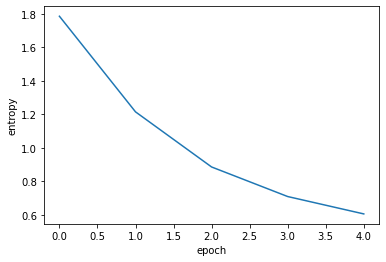

In [23]:
#課題4-3

import numpy as np
import mnist
import matplotlib.pyplot as plt
from pylab import cm
import itertools

#乱数固定
np.random.seed(0)
#学習率
eta = 0.02
al = 0.9
#エポック数
epoch = 5
#画像サイズ
size = 28*28
#中間層の数
M = 50
#画像枚数
train_data_size = 50000
test_data_size = 10000
#クラス数
classes = 10
#データ
X = mnist.download_and_parse_mnist_file("train-images-idx3-ubyte.gz")
Y = mnist.download_and_parse_mnist_file("train-labels-idx1-ubyte.gz")
#バッチサイズ
B = 100
#dropout
rho = 0.1

#シグモイド関数
def sigmoid(x):
    s = 1.0 / (1.0 + np.exp(-x))
    return s

#ソフトマックス関数
def softmax(x):
    u = np.sum(np.exp(x),axis=0)
    return np.exp(x)/u

#ReLU
def ReLU(x):
    return np.clip(x, 0, None)

#ReLUの微分
def del_ReLU(x):
    return np.where(x > 0, 1, 0)


#乱数生成
W_1 = np.random.normal(0, np.sqrt(1/size),(M,size)) #M x size
b_1 = np.random.normal(0, np.sqrt(1/size),M) 
W_2 = np.random.normal(0, np.sqrt(1/M), (classes,M)) #classes x M
b_2 = np.random.normal(0, np.sqrt(1/M), classes)
gamma = np.ones((50,1))
beta = np.zeros((50,1))
delW_1 = delW_2 = delb_1 = delb_2 = delgamma = delbeta = 0

#クロスエントロピー
each_cross_entropy = 0


def dropout(rows, columns, rho):
    total_elements = rows * columns
    num_zeros = rho * total_elements  # 指定された割合に基づいて0の要素数を計算

    # 1で初期化された行列を作成
    matrix = np.ones((rows, columns))

    # 指定された割合の要素を0に設定
    zero_indices = np.random.choice(total_elements, int(num_zeros), replace=False)
    row_indices, col_indices = np.unravel_index(zero_indices, (rows, columns))
    matrix[row_indices, col_indices] = 0

    return matrix


def batch_normalization(x, gamma, beta):
    delta = 1e-7
    mini_ave = np.mean(x, axis = 1, keepdims =True) #列で足し算
    mini_var = np.var(x, axis = 1, keepdims = True)
    x = (x - mini_ave)/np.sqrt(mini_var + delta)
    y = gamma * x + beta
    
    return (mini_ave, mini_var, x, y)

def forward(W_1,W_2,b_1,b_2,data_size,gamma,beta):
    #ランダムなインデックス抽出
    minibach = np.random.choice(data_size, B, replace=False)
    
    #size x Bの行列へ変換
    X_matrix = []
    for i in range(B):
        X_matrix.append(X[minibach[i]].reshape([size]))
    X_matrix = np.array(X_matrix).T #size x B
    X_matrix = X_matrix/255
    
    #全結合層１のあとにバッチ正規化
    (mini_ave, mini_var, x, y) = batch_normalization(np.dot(W_1,X_matrix)+b_1[:,np.newaxis], gamma, beta)
    
    #中間層の出力
#     y_1 = ReLU(y) * dropout(M,B,rho) # M x B ReLU
    y_1 = sigmoid(np.dot(W_1,X_matrix)+b_1[:,np.newaxis]) # M x B sigmoid
    
    #ソフトマックス
    a = np.dot(W_2,y_1) + b_2[:,np.newaxis] # classes x B
    alpha = np.max(a,axis=0)#各列の最大値B個
    y_pred = softmax(a - alpha[np.newaxis,:]) #それぞれのバッチのソフトマックス #10 x B
    y_index_pred = np.argmax(y_pred,axis=0)  #それぞれのバッチの予測
    y_true = np.array([np.eye(10)[y] for y in Y[minibach]],dtype="int8").T  # 10 x B
    
    return(X_matrix, y_1, y_pred,y_index_pred, y_true, minibach)


def test_forward(W_1,W_2,b_1,b_2,train_data_size,test_data_size,gamma,beta):   

    #size x test_data_sizeの行列へ変換
    X_matrix = []
    for i in range(train_data_size,train_data_size + test_data_size):
        X_matrix.append(X[i].reshape([size]))
    X_matrix = np.array(X_matrix).T #size x test_data_size
    X_matrix = X_matrix/255
    
    #バッチ正規化
    (mini_ave, mini_var, x, y) = batch_normalization(np.dot(W_1,X_matrix)+b_1[:,np.newaxis], gamma, beta)

    E = np.sum(mini_ave)/test_data_size
    Var = np.sum(mini_var)/test_data_size
    y = (gamma * x / (Var + 1e-15)**(1/2)) + (beta - gamma*E/(Var + 1e-15)**(1/2))
    
      
    #中間層の出力
#     y_1 = ReLU(y) * (1 - rho) # M x test_data_size
    y_1 = sigmoid(np.dot(W_1,X_matrix)+b_1[:,np.newaxis]) # M x B sigmoid
    
    #ソフトマックス
    a = np.dot(W_2,y_1) + b_2[:,np.newaxis] # classes x test_data_size
    alpha = np.max(a,axis=0)#各列の最大値B個
    y_pred = softmax(a - alpha[np.newaxis,:]) #それぞれのバッチのソフトマックス #10 x test_data_size
    y_index_pred = np.argmax(y_pred,axis=0)  #それぞれのバッチの予測
#     y_true = np.array([np.eye(10)[y] for y in Y[minibach]],dtype="int8").T  # 10 x test_data_size
    
    return y_index_pred


#シグモイドの微分
def del_sigmoid(y):
    return (1 - y)  * y

def backward(y_pred, y_true, y_1, X_matrix, W_1, W_2,b_1, b_2, gamma, beta):

# def backward(y_pred, y_true, y_1, X_matrix, W_1, W_2,b_1, b_2, gamma, beta,delW_1, delW_2,delb_1, delb_2, delgamma, delbeta):
    #中間層から出力層の逆伝播
    #del En/del akを求める
    del_en_del_ak = (y_pred - y_true)/B #C x B
    # print(del_en_del_ak)
    #del En/del X
    del_en_del_x = np.dot(W_2.T,del_en_del_ak) # M x B
    # print(del_en_del_x) 
    #del En/del W_2
    del_en_del_w_2 = np.dot(del_en_del_ak, y_1.T) #C x M
    #del En/del b_2
    del_en_del_b_2 = np.sum(del_en_del_ak,axis=1) #B
    # print(del_en_del_b_2)

    
    #活性化関数の逆伝搬
#     del En/del X      ReLU    
#     del_en_del_x_1 = del_en_del_x * del_ReLU(y_1)
#     #del En/del X 　　sigmoid
    del_en_del_x_1 = del_en_del_x * del_sigmoid(y_1)
    
    
    #全結合層１のあとのバッチ正規化
    (mini_ave, mini_var, x, y) = batch_normalization(np.dot(W_1,X_matrix)+b_1[:,np.newaxis], gamma, beta)
    X_input = np.dot(W_1,X_matrix)+b_1[:,np.newaxis]
    
    
    #バッチ正規化の逆伝搬
    del_norm_x = del_en_del_x_1 * gamma
    del_var = np.sum(del_norm_x * (X_input - mini_ave)*(-1) / 2 * (mini_var + 1e-7) ** (-3/2), axis = 0, keepdims =True)
    del_ave = np.sum(del_norm_x * (-1)/ (mini_var + 1e-7) ** (1/2), axis = 0, keepdims =True) + del_var * np.sum((-2)*(X_input - mini_ave), axis = 0, keepdims =True) / B
    del_X = del_norm_x / (mini_var + 1e-7) ** (1/2) + del_var * 2 * (X_input - mini_ave) / B + del_ave / B
    del_gamma = np.sum(del_en_del_x_1 * x, axis = 1, keepdims =True)
    del_beta = np.sum(del_en_del_x_1, axis = 1, keepdims =True)
               
    
    #全結合層１の逆伝搬
    #del En/del W
    del_en_del_w_1 = np.dot(del_X, X_matrix.T)
    #del En/del b
    del_en_del_b_1 = np.sum(del_X, axis=1)

    

    #パラメータの更新
#     delW_1 = delW_1 * al - (eta * del_en_del_w_1)
#     W_1 = W_1 + delW_1
#     delW_2 = delW_2 * al - (eta * del_en_del_w_2)
#     W_2 = W_2 + delW_2
#     delb_1 = delb_1 * al - (eta * del_en_del_b_1)
#     b_1 = b_1 + delb_1
#     delb_2 = delb_2 * al - (eta * del_en_del_b_2)
#     b_2 = b_2 + delb_2
#     delgamma = delgamma * al - (eta * del_gamma)
#     gamma = gamma + delgamma
#     delbeta = delbeta * al - (eta * del_beta)
#     beta = beta + delbeta
    
    W_1 = W_1 - eta * del_en_del_w_1
    W_2 = W_2 - eta * del_en_del_w_2
    b_1 = b_1 - eta * del_en_del_b_1
    b_2 = b_2 - eta * del_en_del_b_2
    gamma = gamma - eta * del_gamma
    beta = beta - eta * del_beta

    #クロスエントロピーの計算
    cross_entropy_list = -np.sum(y_true * np.log(y_pred + 1e-15),axis = 0)
    each_cross_entropy = np.sum(cross_entropy_list)/B
    
    return (each_cross_entropy,W_1,W_2,b_1,b_2,gamma,beta)



#正解率
def list_match_rate(list1, list2):
    # 2つのリストの要素数を取得
    len1 = len(list1)
    len2 = len(list2)

    # 空のリストが渡された場合、一致率は0とします
    if len1 == 0 or len2 == 0:
        return 0.0
    
    # 一致する要素の数を計算
    match_count = sum(1 for a, b in zip(list1, list2) if a==b)
    # 一致率を計算
    match_rate = (match_count / len1) * 100
    
    return match_rate



#epoch
j = 0
entropy_list = []
x = list(range(epoch))
while (epoch > 0):
    j += 1
    print("epoch" + str(j))
    sum_entropy = 0
#     W_1 = np.load("W1.npy")
#     W_2 = np.load("W2.npy")
#     b_1 = np.load("b1.npy")
#     b_2 = np.load("b2.npy")
#     gamma = np.load("gamma.npy")
#     beta = np.load("beta.npy")

    y_all_true = []
    y_all_pred = []
    
    #繰り返し学習
    for i in range(int(train_data_size/B)):
        (X_matrix, y_1, y_pred,y_index_pred, y_true, minibach) = forward(W_1,W_2,b_1,b_2,train_data_size, gamma, beta)
        (each_cross_entropy,W_1,W_2,b_1,b_2,gamma,beta) = backward(y_pred, y_true, y_1, X_matrix, W_1, W_2,b_1, b_2, gamma, beta)
#         (each_cross_entropy,W_1,W_2,b_1,b_2,gamma,beta) = backward(y_pred, y_true, y_1, X_matrix, W_1, W_2,b_1, b_2, gamma, beta,delW_1, delW_2,delb_1, delb_2, delgamma, delbeta)

        sum_entropy += each_cross_entropy
        y_all_true.append(Y[minibach])
        y_all_pred.append(y_index_pred)
    cross_entropy = sum_entropy*B/train_data_size
    print("クロスエントロピー:"+ str(cross_entropy))
    entropy_list.append(cross_entropy)
    print("正解率" + str(list_match_rate(np.array(y_all_true).ravel(), np.array(y_all_pred).ravel())))#ミニバッチの正解率
    
    #保存
#     np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/W1.npy",W_1)
#     np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/W2.npy",W_2)
#     np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/b1.npy",b_1)
#     np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/b2.npy",b_2)
#     np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/gamma.npy",gamma)
#     np.save("/Users/jiho/OneDrive - Kyoto University/三回生後期/実験　画像/beta.npy",beta)

    #テストデータで評価
    y_index_pred = test_forward(W_1,W_2,b_1,b_2,train_data_size,test_data_size,gamma,beta)
    number_list = list(range(train_data_size, train_data_size + test_data_size))
    print("テスト正解率" + str(list_match_rate(Y[number_list], y_index_pred)))
    epoch -= 1
    
#結果
plt.plot(x,entropy_list)
plt.xlabel("epoch")
plt.ylabel("entropy")
plt.show()

In [24]:
#課題５
#課題１

import numpy as np
import mnist
import matplotlib.pyplot as plt
from pylab import cm

#画像サイズ
size = 28*28
#中間層の数
M = 50
#画像枚数
amount = 10000
#クラス数
classes = 10
#テストデータ
X = mnist.download_and_parse_mnist_file("t10k-images-idx3-ubyte.gz")
Y = mnist.download_and_parse_mnist_file("t10k-labels-idx1-ubyte.gz")


#キーボードからの入力

try:
    idx = int(input("好きな数字を入力してください"))
    
except ValueError:
    print("エラー: 数値以外の入力が検出されました。")
    exit()
    
else:
    #size次元ベクトルへ変換
    X_vector = X[idx].reshape([size])
    X_vector = X_vector/255
    #シグモイド関数
    def sigmoid(x):
        return 1.0 / (1.0 + np.exp(-x))
    #ソフトマックス関数
    def softmax(x):
        u = np.sum(np.exp(x))
        return np.exp(x)/u
    #乱数生成
    W_1 = np.load("W1.npy")
    W_2 = np.load("W2.npy")
    b_1 = np.load("b1.npy")
    b_2 = np.load("b2.npy")
    gamma = np.load("gamma.npy")
    beta = np.load("beta.npy")
    #中間層の出力
    y_1 = sigmoid(np.dot(W_1,X_vector)+b_1)

    #出力
    a = np.dot(W_2,y_1) + b_2
    alpha = np.full(classes,np.amax(a))
    y_2 = softmax(a-alpha)
    y = np.argmax(y_2)
    #結果
    plt.imshow(X[idx], cmap=cm.gray)
    plt.show()
    print("正しい結果: " + str(Y[idx]))
    print("予想結果: " + str(y))

好きな数字を入力してください 59999


IndexError: index 59999 is out of bounds for axis 0 with size 10000

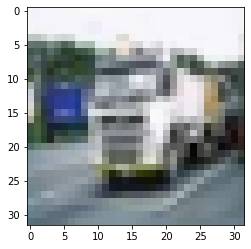

9


In [7]:
#発展課題A

import numpy as np
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo,encoding='bytes')
    X = np.array(dict[b'data'])
    X = X.reshape((X.shape[0],3,32,32))
    Y = np.array(dict[b'labels'])
    return X,Y

X,Y = unpickle("./cifar-10-batches-py//data_batch_1")

import matplotlib.pyplot as plt
idx = 1000
plt.imshow(X[idx].transpose((1,2,0))) # X[idx] が (3*32*32) になっているのを (32*32*3) に変更する．
plt.show() #トラックの画像が表示されるはず
print(f'{Y[idx]}') #9番（truck）が表示されるはず